# Regression Analysis with Sampling
- Using SMOGN to sample data and make better predictions
- This is the best performing model. Modeling.ipynb doesn't use sampling so ignore, but this work is based on that nb.

In [7]:
# !pip install smogn

In [1]:
import smogn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

from xgboost import XGBRegressor


In [2]:
## read in data, drop cols, separate into X, y
df = pd.read_csv("data/dataModel.csv").dropna()
df.head()

,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Year,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,10694,0.838,0.256,1989.0,17.0,0.537,0.810,8.0,-6.213,0.0,0.1290,0.000709,0.892000,0.0579,0.667,134.096,136933.0,4.0
1,4528,0.955,0.867,0.0,1.0,0.342,0.377,11.0,-13.728,1.0,0.0401,0.943000,0.106000,0.1220,0.506,76.672,256827.0,3.0
2,3297,0.056,0.748,0.0,0.0,0.663,0.614,2.0,-7.712,1.0,0.2490,0.077100,0.006890,0.2960,0.248,82.060,87800.0,4.0
3,4435,0.740,1.000,0.0,26.0,0.163,0.262,1.0,-9.781,1.0,0.0306,0.792000,0.167000,0.1160,0.278,170.527,205347.0,4.0
4,4319,0.673,0.582,0.0,0.0,0.262,0.753,9.0,-11.859,1.0,0.0987,0.330000,0.000009,0.7180,0.087,138.553,101947.0,4.0


In [3]:
## custom train test split?
import random

def custom_split(data, test_prop=0.2):
    random.seed(699)

    train_prop = (1-test_prop)
    test_prop = test_prop

    num_train = round(len(df) * train_prop)
    num_test = round(len(df) * test_prop)

    train_idx = random.sample(range(0, len(df)-1), num_train)
    test_idx = random.sample(range(0, len(df)-1), num_test)

    _X_train = data.iloc[train_idx].drop("Popularity", axis=1).reset_index(drop=True)
    _y_train = data.iloc[train_idx]["Popularity"].reset_index(drop=True)

    _X_test = data.iloc[test_idx].drop("Popularity", axis=1).reset_index(drop=True)
    _y_test = data.iloc[test_idx]["Popularity"].reset_index(drop=True)

    print(len(df) == len(train_idx) + len(test_idx))

    return _X_train, _X_test, _y_train, _y_test

In [4]:
## make the split with the custom function
X_train, X_test, y_train, y_test = custom_split(df, test_prop=0.2)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=699)

True


In [5]:
df_train = X_train.join(y_train).sample(5000).reset_index(drop=True)

df_train.Popularity.describe()
# df_train.isnull().sum()
# y_train.isnull().sum()

count    5000.000000
mean       13.136800
std        15.309558
min         0.000000
25%         1.000000
50%         7.000000
75%        20.000000
max        84.000000
Name: Popularity, dtype: float64

In [6]:
df_smogn = smogn.smoter(
    data = df_train,
    y = "Popularity",
    k = 10,
    rel_thres=0.7,
    samp_method = "extreme"
    # rel_xtrm_type = "high"
)

# rel_thres is weird, but 0.7 best results thus far; 

r_index: 100%|##########| 295/295 [00:00<00:00, 380.10it/s]


In [7]:
df_smogn

,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Popularity
0,5023,0.694616,0.000660,4.421811,0.791415,0.476055,9.000000,0.000,1.000000,0.042173,0.680487,0.000130,0.097768,0.834249,126.860819,113518.514220,4.0,35.435537
1,7470,0.392898,0.443615,881.906064,0.674442,0.545091,9.443615,0.000,0.556385,0.073996,0.745881,0.000072,0.241564,0.891452,151.863418,115041.290049,4.0,38.731473
2,4587,0.544104,0.639303,1461.577134,0.710356,0.554457,10.457932,0.000,0.271034,0.350380,0.316059,0.000045,0.268497,0.558264,106.813796,115632.422517,4.0,35.436580
3,8418,0.997527,0.000000,1959.981190,0.553946,0.427389,0.072960,0.000,1.000000,0.042497,0.805987,0.520745,0.178341,0.843935,97.606407,121164.627162,4.0,37.168659
4,7383,0.764827,0.572354,1146.998293,0.579657,0.753164,9.000000,0.000,0.427646,0.048625,0.293995,0.000364,0.132213,0.561270,132.089682,109152.771491,4.0,37.573765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,6315,0.263000,0.000000,1957.000000,0.497000,0.729000,9.000000,-6.780,0.000000,0.057200,0.717000,0.000000,0.297000,0.837000,125.004000,129773.000000,4.0,2.000000
4996,33,0.479000,0.252000,0.000000,0.177000,0.782000,7.000000,-5.992,1.000000,0.039100,0.055600,0.000120,0.097700,0.312000,182.142000,251587.000000,4.0,0.000000
4997,3954,0.959000,0.596000,1975.000000,0.603000,0.433000,7.000000,-10.306,1.000000,0.027700,0.237000,0.000013,0.098000,0.576000,103.617000,166960.000000,4.0,22.000000
4998,11442,0.544000,0.000000,1995.000000,0.442000,0.972000,7.000000,-6.440,1.000000,0.104000,0.000004,0.015200,0.328000,0.469000,133.658000,128040.000000,4.0,24.000000


In [8]:
## split back into X_train, y_train
X_train = df_smogn.drop("Popularity", axis=1)
y_train = df_smogn.Popularity

In [9]:
## scale the data
# scaler = RobustScaler()
# X_train =  scaler.fit_transform(X_train)
# x_test = scaler.transform(X_test)

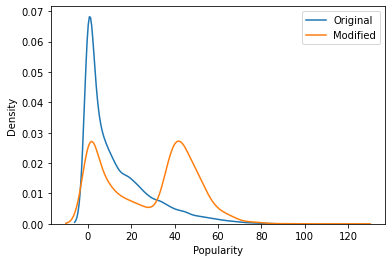

In [10]:
## distribution plot
sns.kdeplot(df['Popularity'], label = "Original")
sns.kdeplot(df_smogn['Popularity'], label = "Modified")
plt.legend();


### Dummy Regressor

In [11]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)

DummyRegressor()

In [12]:
dummy_train_r2 = dummy_reg.score(X_train, y_train)
dummy_test_r2 = dummy_reg.score(X_test, y_test)
dummy_preds = dummy_reg.predict(X_test)

dummy_RMSE = np.sqrt(mean_squared_error(y_test, dummy_preds))
dummy_MAE = mean_absolute_error(y_test, dummy_preds)

In [13]:
print(f'train r2: {dummy_train_r2}')
print(f'test r2: {dummy_test_r2}')
print(f'mae: {dummy_MAE}')
print(f'rmse: {dummy_RMSE}')
print(f'mse: {mean_squared_error(y_test, dummy_preds)}')

train r2: 0.0
test r2: -1.061017684317218
mae: 19.437451893152964
rmse: 21.43685407994386
mse: 459.53871284480573


## Model Pipeline
After testing out many models, best performing ones are:
- Random Forest
- KNeighbors
- XGBoost
- Gradient Boosting Regressor (^^)

- GS for best parameters

In [14]:
est1 = GradientBoostingRegressor(loss="lad", max_features=None,
                                 min_samples_split=4, max_depth=7)

est2 = RandomForestRegressor(bootstrap=False, max_features="sqrt",
                             min_samples_split=3, n_estimators=100)

est3 = KNeighborsRegressor(n_neighbors=5, weights="distance")

est4 = XGBRegressor(colsample_bytree=0.9, eval_metric="mae",
                        gamma=0.3, max_depth=3, min_child_weight=2,
                        objective="reg:squarederror", subsample=1.0)

stack_reg = StackingRegressor(estimators=[('est1', est2),
                                          ('est2', est4)
                                          ],
                              final_estimator=est1)

## Let's prepare a pipeline for testing
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', stack_reg)
])

# pipe.fit(X_train, y_train)

In [15]:
# (-8.583437741074725,
#  {'reg__bootstrap': False,
#   'reg__max_features': 'sqrt',
#   'reg__min_samples_split': 3,
#   'reg__n_estimators': 100})
params_RF = {'reg__n_estimators': [100,200],
             'reg__max_features': ["log2", "sqrt", "auto"],
             'reg__min_samples_split': [2, 3, 4],
             'reg__bootstrap': [True, False]}

# (-9.79038707792391, {'reg__n_neighbors': 5, 'reg__weights': 'distance'})
params_KNN = {'reg__n_neighbors': [5, 8, 10],
              'reg__weights': ["uniform", "distance"]}

# (-9.026157811283062,
#  {'reg__colsample_bytree': 0.9,
#   'reg__eval_metric': 'mae',
#   'reg__gamma': 0.3,
#   'reg__max_depth': 3,
#   'reg__min_child_weight': 2,
#   'reg__objective': 'reg:squarederror',
#   'reg__subsample': 1.0})
params_XGB = {'reg__objective': ["reg:squarederror", "reg:linear"],
              'reg__eval_metric': ["mae", "rmse"],
              'reg__min_child_weight': [2,4,5],
              'reg__gamma':[i/10.0 for i in range(3,6)],
              'reg__subsample':[i/10.0 for i in range(6,11)],
              'reg__colsample_bytree':[i/10.0 for i in range(6,11)],
              'reg__max_depth': [2,3,4]}

# (-8.46321875834909,
#  {'reg__loss': 'lad',
#   'reg__max_depth': 7,
#   'reg__max_features': None,
#   'reg__min_samples_split': 4})
params_GBR = {'reg__loss': ["lad", "ls"],
              'reg__min_samples_split': [2, 4, 5],
              'reg__max_depth': [3, 5, 7],
              'reg__max_features': [None, 'auto', 'sqrt', 'log2']}

In [16]:
%%time
## gridsearch it with correct parameter grid

gs = GridSearchCV(pipe, param_grid={}, scoring="neg_mean_absolute_error", n_jobs=-1)
gs.fit(X_train, y_train)

gs_preds = gs.predict(X_test)

CPU times: user 38.4 s, sys: 1.22 s, total: 39.7 s
Wall time: 47.6 s


In [17]:
gs.best_score_, gs.best_params_

(-9.203122232707553, {})

In [18]:

gs_RMSE = np.sqrt(mean_squared_error(y_test, gs_preds))
gs_MAE = mean_absolute_error(y_test, gs_preds)

print(f'mae: {gs_MAE}')
print(f'rmse: {gs_RMSE}')
print(f'mse: {mean_squared_error(y_test, gs_preds)}')

mae: 8.846468896546497
rmse: 13.211499924586704
mse: 174.5437302573545


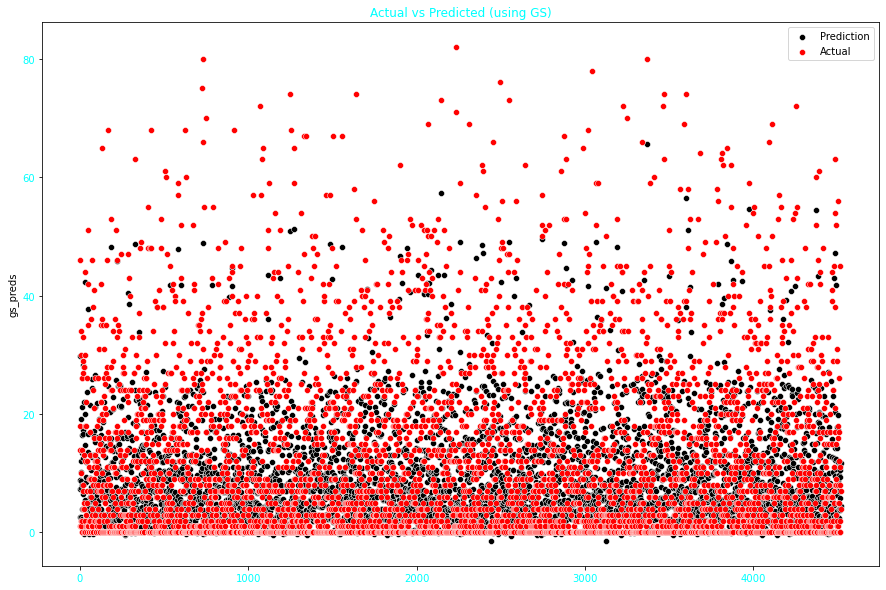

In [19]:
fig, ax = plt.subplots(figsize=(15,10))

preds_df = pd.DataFrame(list(zip(y_test, gs_preds)), columns=["y_test", "gs_preds"])
preds_df["absolute_error"] = preds_df["gs_preds"] - preds_df["y_test"]
preds_df

sns.scatterplot(x=preds_df.index, y="gs_preds", data=preds_df, ax=ax, color="black", label="Prediction")
# plt.plot(y_test - gs_preds, marker='o',linestyle='')
sns.scatterplot(x=preds_df.index, y="y_test", data=preds_df, ax=ax, color="red", label="Actual")

plt.title("Actual vs Predicted (using GS)", color="cyan");
plt.xticks(color="cyan")
plt.yticks(color="cyan");


In [22]:
## write the predictions dataframe for Brian
# preds_df.to_csv("data/final_predictions.csv", index=False)

In [23]:
gs.

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reg',
                                        StackingRegressor(estimators=[('est1',
                                                                       RandomForestRegressor(bootstrap=False,
                                                                                             max_features='sqrt',
                                                                                             min_samples_split=3)),
                                                                      ('est2',
                                                                       XGBRegressor(base_score=None,
                                                                                    booster=None,
                                                                                    colsample_bylevel=None,
                                                                               